# transfer spatial domain from GBM dataset (training model from data)

In [ ]:
# scanpy scarches squidpy, must be loaded

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import scarches as sca
import torch
from scipy.sparse import csr_matrix

 captum (see https://github.com/pytorch/captum).


In [2]:
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load target adata for prediction
target_adata_raw = sc.read_h5ad('./GBM_data/P137_A1.h5ad')
target_adata_raw.var_names_make_unique()
target_adata_raw.obs['slide'] = 'target'
# smooth target adata
sq.gr.spatial_neighbors(target_adata_raw, coord_type="grid")
conn = target_adata_raw.obsp['spatial_connectivities']
X = target_adata_raw.X
if not isinstance(X, np.ndarray):
    X = X.toarray()
neighbor_sum = conn @ X
n_neighbors = np.array(conn.sum(axis=1)).flatten()
n_neighbors_safe = np.where(n_neighbors == 0, 1, n_neighbors)
neighbor_mean = neighbor_sum / n_neighbors_safe[:, None]
X_smoothed = 0.6 * X + 0.4 * neighbor_mean
target_adata_raw.X = csr_matrix(X_smoothed)

In [4]:
# load source adata for reference
# The source data can be downloaded at https://doi.org/10.5281/zenodo.13846808
# spatial_domain_table_ER.csv can be downloaded in ./data/

sp_path_GBM = './GBM_data/'
sp_files_GBM = os.listdir(sp_path_GBM)
sp_files_GBM = [x for x in sp_files_GBM if '.h5ad' in x]
sp_files_GBM.sort()
slide_ids_GBM = [x.split('.h5ad')[0] for x in sp_files_GBM]
tmp_df = pd.read_csv('./GBM_data/spatial_domain_table_ER.csv',index_col=0)
adata_list = []
for i, tmp_slide in enumerate(slide_ids_GBM):
    tmp_ad = sc.read_h5ad(f'{sp_path_GBM}{tmp_slide}.h5ad')
    tmp_ad.var_names_make_unique()
    tmp_ad.obs['spatial_domain'] = [f'SD-{x:01}' for x in tmp_df.loc[tmp_ad.obs_names]['spatial_domain']]
    adata_list.append(tmp_ad)
source_adata_raw = sc.concat(adata_list)
source_adata_raw.var_names_make_unique()

In [5]:
varlist_intersection = [var_name for var_name in target_adata_raw.var_names if var_name in source_adata_raw.var_names]
print(f"overlap gene num: {len(varlist_intersection)}")
source_adata = source_adata_raw[:,varlist_intersection].copy()
target_adata = target_adata_raw[:,varlist_intersection].copy()

overlap gene num: 16306


In [6]:
sca.models.SCVI.setup_anndata(source_adata, batch_key='slide', labels_key='spatial_domain')
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [7]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 101/101: 100%|██████████| 101/101 [13:58<00:00,  8.34s/it, v_num=1, train_loss_step=7.49e+3, train_loss_epoch=7.76e+3]

`Trainer.fit` stopped: `max_epochs=101` reached.


Epoch 101/101: 100%|██████████| 101/101 [13:58<00:00,  8.30s/it, v_num=1, train_loss_step=7.49e+3, train_loss_epoch=7.76e+3]


In [8]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")
scanvae.train(max_epochs=20)
source_adata.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(source_adata.obs.predictions == source_adata.obs['spatial_domain'])))

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [07:09<00:00, 21.17s/it, v_num=1, train_loss_step=7.07e+3, train_loss_epoch=7.77e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [07:10<00:00, 21.50s/it, v_num=1, train_loss_step=7.07e+3, train_loss_epoch=7.77e+3]
Acc: 0.970156059991893


In [9]:
ref_path = f'./ref_model/'
scanvae.save(ref_path, overwrite=True)

In [10]:
savekey = 'spatial_domain' in target_adata.obs.columns
if savekey:
    tmp_obs = target_adata.obs['spatial_domain']
target_adata.obs['spatial_domain'] = scanvae.unlabeled_category_

In [11]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []

INFO     File ./ref_model/model.pt already downloaded                                                              


In [12]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [01:25<00:00,  1.15it/s, v_num=1, train_loss_step=8.4e+3, train_loss_epoch=8.19e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s, v_num=1, train_loss_step=8.4e+3, train_loss_epoch=8.19e+3]


In [13]:
if savekey:
    target_adata.obs['spatial_domain'] = tmp_obs
target_adata.obs['predict_SD'] = model.predict()

In [14]:
domain_color_dict = {'SD-8':'#AFB4B7','SD-9':'#6A6A6A',
                     'SD-2':'#762A86','SD-6':'#982581',
                     'SD-3':'#B43826','SD-5':'#81C08F',
                     'SD-4':'#5DB998','SD-7':'#FA6E47',
                     'SD-0':'#F4A947','SD-1':'#F98847'}

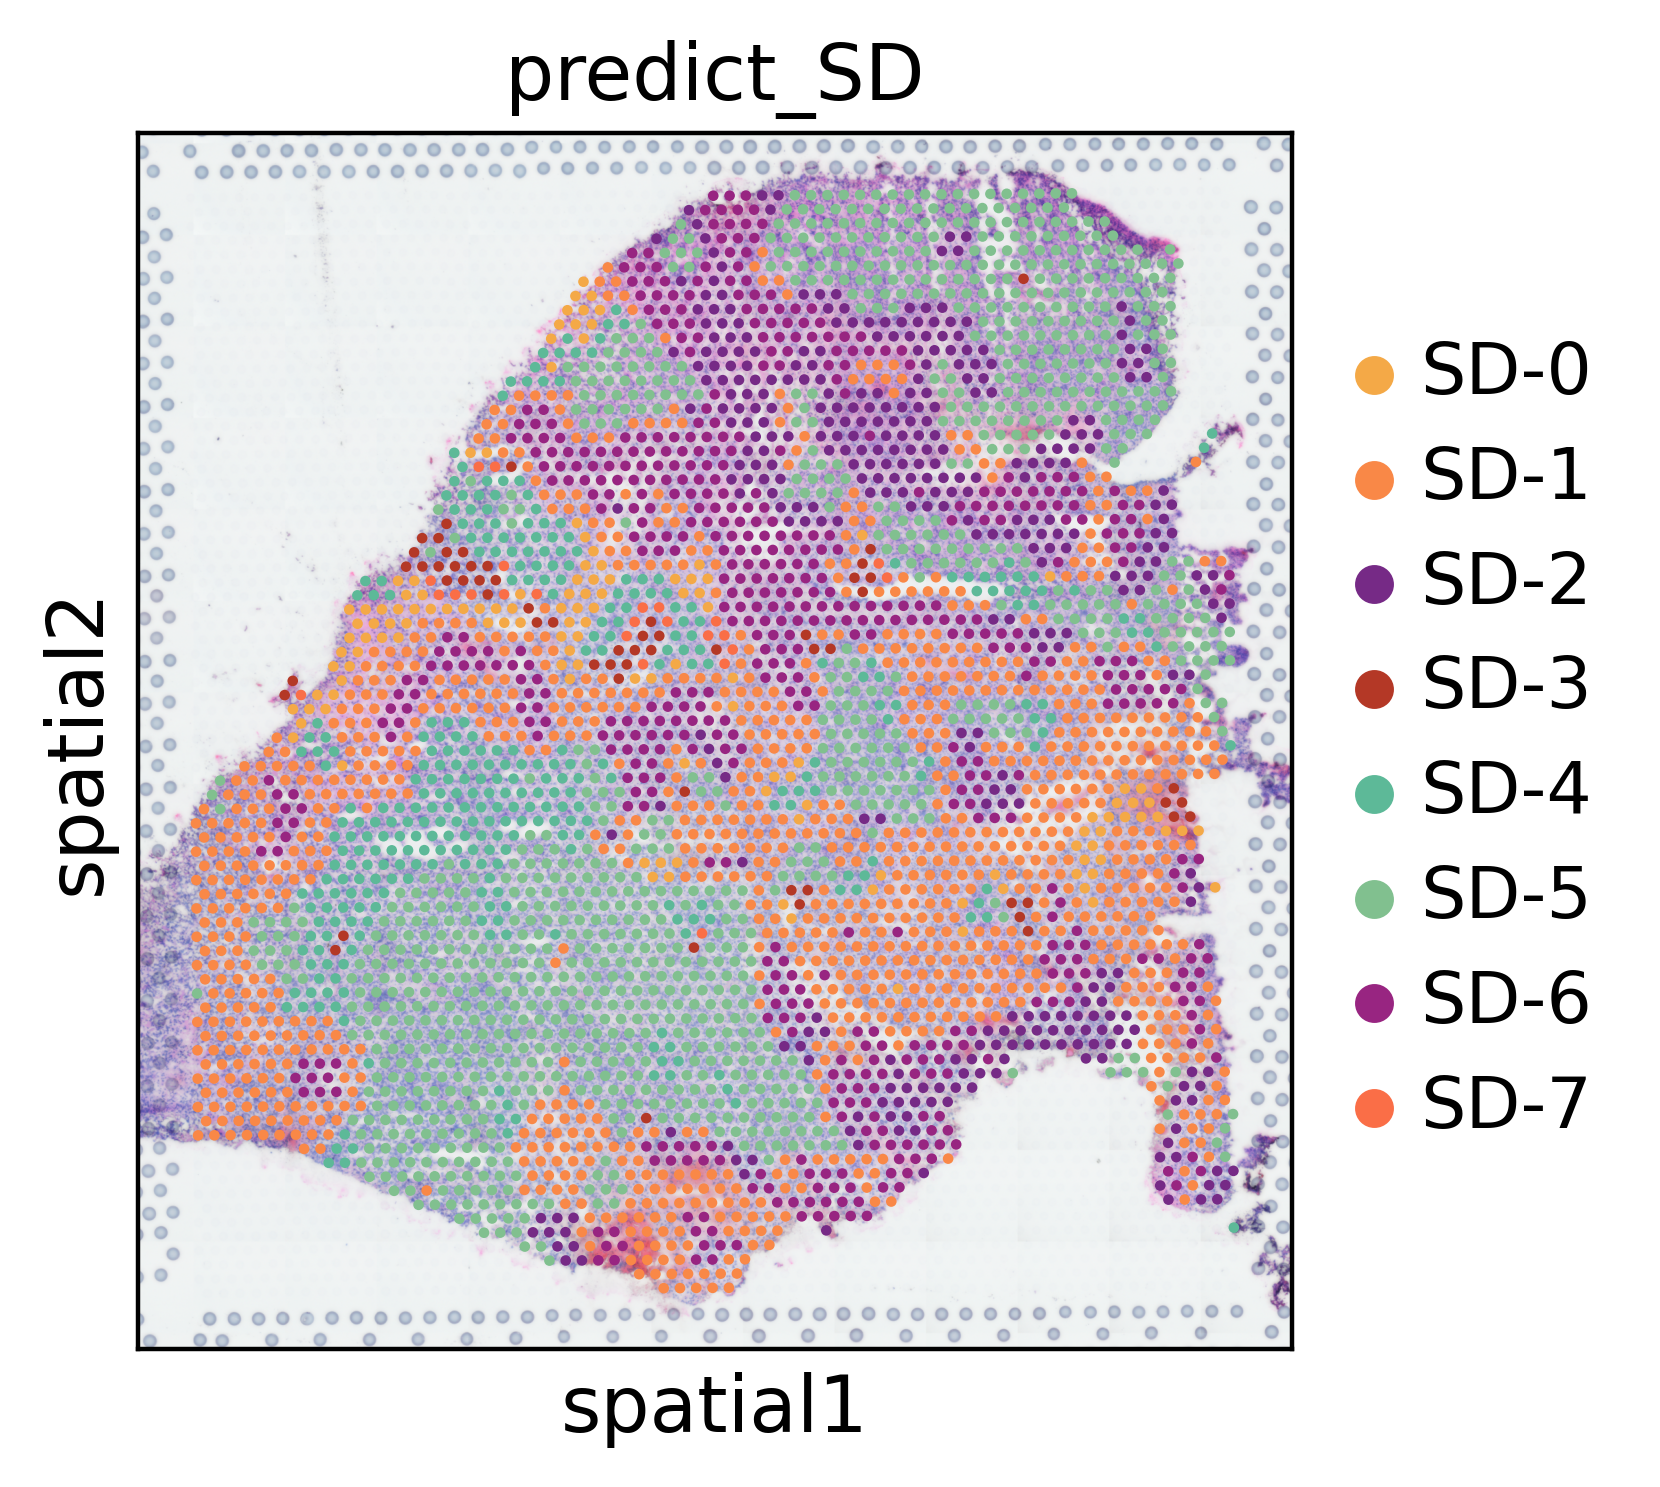

In [15]:
sc.pl.spatial(target_adata, color='predict_SD', palette=domain_color_dict)

In [16]:
target_adata.write_h5ad(f'./output/adata_predict_SD.h5ad')